In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import timedelta

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")
conn = engine.connect()

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


#### Use the function `calc_temps` to calculate the tmin, tavg, and tmax for a year in the data set

In [10]:
print(calc_temps('2016-08-23', '2017-08-23'))

[(58.0, 74.59058295964125, 87.0)]


In [11]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
results = (calc_temps('2016-12-30', '2017-12-30'))
mint = results[0][0]
avgt = results[0][1]
maxt = results[0][2]
print(f'Minimum temperature: {mint}, Average temperature: {avgt}, Highest temperature: {maxt}')

Minimum temperature: 58.0, Average temperature: 74.097232079489, Highest temperature: 87.0


In [12]:
a = np.array([mint,maxt, avgt])
error = np.std(a)

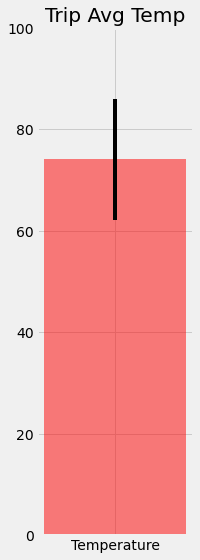

In [13]:
fig = plt.figure(figsize=(3,8))
plt.bar(x='Temperature', height=avgt, yerr=error, align='center', color='red', alpha=0.5, rasterized=True,)

plt.title('Trip Avg Temp')
plt.ylim(0,100)
plt.tight_layout()
plt.show()

### Daily Rainfall Average

#### Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.

In [14]:
year_old = dt.date(2017, 8, 23) - dt.timedelta(days=365)
year_old_data = session.query(Measurement.station, Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_old).all()
year_old_df = pd.DataFrame(year_old_data).set_index('station').sort_index()
rainfall_df = year_old_df.groupby('station').sum()
rainfall_df

,prcp
station,
USC00513117,48.51
USC00514830,33.24
USC00516128,147.81
USC00517948,4.59
USC00519281,70.03
USC00519397,16.09
USC00519523,38.01


#### Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

In [15]:
station_data = session.query(station.station, station.name, station.latitude, station.longitude, station.elevation).all()
station_df = pd.DataFrame(station_data).set_index('station')
rainfall_df.join(station_df).sort_values(by='prcp', ascending=False)

,prcp,name,latitude,longitude,elevation
station,,,,,
USC00516128,147.81,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
USC00519281,70.03,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
USC00513117,48.51,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
USC00519523,38.01,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
USC00514830,33.24,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
USC00519397,16.09,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
USC00517948,4.59,"PEARL CITY, HI US",21.39340,-157.97510,11.9


In [16]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

### calculate the daily normals for your trip ||  push each tuple of calculations into a list called `normals`

#### Set the start and end date of the trip

In [17]:
start_date = '2017-08-01'
end_date = '2017-08-07'

In [20]:
start = dt.datetime.strptime(start_date, '%Y-%m-%d')
end = dt.datetime.strptime(end_date, '%Y-%m-%d')

trip = [start + timedelta(days=x) for x in range((end-start).days + 1)]

In [21]:
trip

[datetime.datetime(2017, 8, 1, 0, 0),
 datetime.datetime(2017, 8, 2, 0, 0),
 datetime.datetime(2017, 8, 3, 0, 0),
 datetime.datetime(2017, 8, 4, 0, 0),
 datetime.datetime(2017, 8, 5, 0, 0),
 datetime.datetime(2017, 8, 6, 0, 0),
 datetime.datetime(2017, 8, 7, 0, 0)]

In [22]:
dates = (datetime.strptime(ts, '%Y-%m-%d %H:%M:%S') for ts in trip)
date_strings = [datetime.strftime(d, '%m-%d-%Y') for d in dates]

print(trip)

NameError: name 'datetime' is not defined

In [ ]:
# Strip off the year and save a list of strings in the format %m-%d

In [ ]:
# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

In [ ]:
# Plot the daily normals as an area plot with `stacked=False`

## Close Session